# A/B Test Analysis

In this notebook, we analyze the impact of different first-order discount levels (0%, 10%, 20%, 30%) on new user GMV (Gross Merchandise Value). Using the prepared first-order dataset, we conduct statistical tests to evaluate whether increasing discount levels lead to significant GMV uplift. The analysis focuses only on successfully delivered first orders, as these generate real revenue.

## Load Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# Load prepared first-order data
df_first = pd.read_csv('/Users/Cathaml/Desktop/first_orders_with_group.csv')

# Quick check
df_first.head()

,Restaurant ID,Restaurant name,Subzone,City,Order ID,Order Placed At,Order Status,Delivery,Distance,Items in order,...,Restaurant compensation (Cancellation),Restaurant penalty (Rejection),KPT duration (minutes),Rider wait time (minutes),Order Ready Marked,Customer complaint tag,Customer ID,order_num,group,group_label
0,20882652,Aura Pizzas,DLF Phase 1,Delhi NCR,6149741531,2024-09-03 21:41:00,Delivered,Zomato Delivery,5km,"1 x Murgh Amritsari Seekh Pide, 1 x Indian Mas...",...,NaN,NaN,16.62,4.4,Correctly,NaN,000285ae83ecf06a92b936d4f5b74342edb0e1940e1f00...,1,C,20%
1,21173951,Aura Pizzas,Vasant Kunj,Delhi NCR,6160981259,2024-09-08 17:43:00,Rejected,Zomato Delivery,2km,1 x Bageecha Pizza,...,451.33,NaN,14.28,3.9,Incorrectly,NaN,00062fa202370fdd3076b794ec9358f36e35469bb8e5ff...,1,D,30%
2,20882652,Aura Pizzas,DLF Phase 1,Delhi NCR,6511045577,2025-01-10 01:38:00,Delivered,Zomato Delivery,3km,"1 x Tripple Cheese Pizza, 1 x Masala Potato Pi...",...,NaN,NaN,14.63,6.1,Correctly,NaN,001ab5fc3ee158b4d22e106897cee9b355e6eed50f163e...,1,A,0%
3,20882652,Aura Pizzas,DLF Phase 1,Delhi NCR,6432202507,2024-12-13 22:26:00,Delivered,Zomato Delivery,2km,"1 x Murgh Amritsari Seekh Pizza, 1 x Makhani P...",...,NaN,NaN,29.47,2.9,Correctly,NaN,001fdf2511dd137361424c9c15ea54774476691ceec5fa...,1,C,20%
4,20659868,Aura Pizzas,Sector 4,Delhi NCR,6240870348,2024-10-11 18:50:00,Delivered,Zomato Delivery,7km,1 x All About Chicken Pizza,...,NaN,NaN,16.27,3.0,Correctly,NaN,002afbd83626f0c699892fcb07b2ddf3858911482647b6...,1,C,20%


## Filter Delivered Orders Only
Only successfully delivered orders are included in the analysis, as rejected or cancelled orders do not contribute to revenue.

In [6]:
# Keep only delivered first orders
df_first = df_first[df_first['Order Status'] == 'Delivered'].copy()

# Confirm remaining orders
print(f"Delivered first orders: {df_first.shape[0]}")
df_first['Order Status'].value_counts()

Delivered first orders: 11497


Order Status
Delivered    11497
Name: count, dtype: int64

## Group Size Check
The first step is to confirm that the simulated discount groups are balanced, to ensure the validity of our comparisons

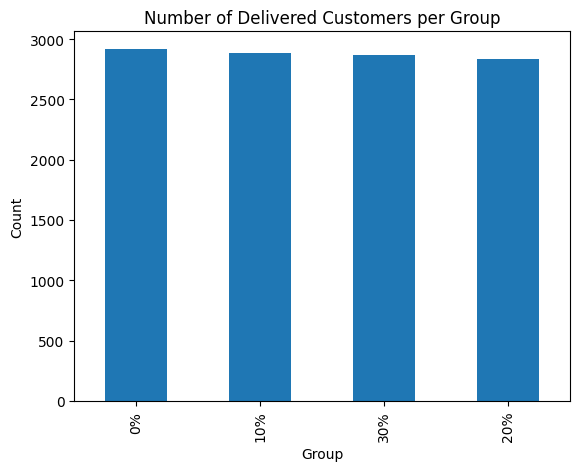

,count,mean,std
group_label,,,
0%,2918,690.779236,496.271013
10%,2881,709.217352,541.611138
20%,2831,686.849792,452.963476
30%,2867,675.069348,429.313623


In [7]:
# Customers per group
group_counts = df_first['group_label'].value_counts()
group_counts.plot(kind='bar', title='Number of Delivered Customers per Group', ylabel='Count', xlabel='Group')
plt.show()

# Summary stats
df_first.groupby('group_label')['Total'].agg(['count', 'mean', 'std'])

Groups are well balanced, with ~2800-2900 users per group. Average GMV per group is similar.

## GMV Distribution Visualization
The distribution of first order GMV (Total) by discount group is shown below:

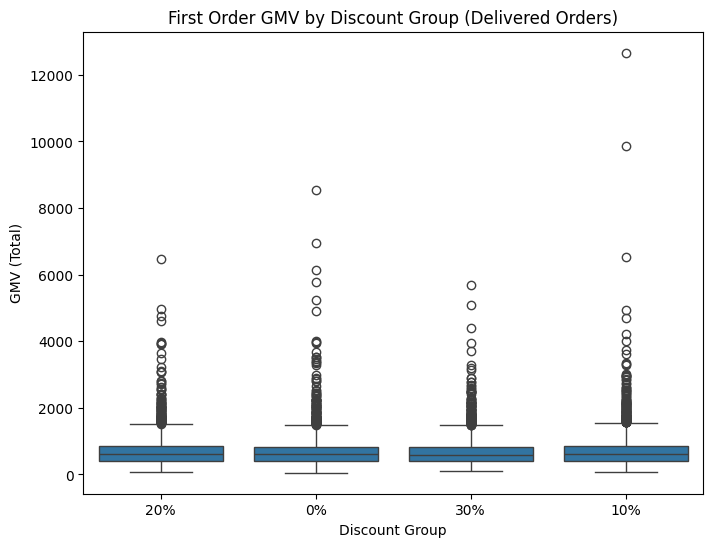

In [8]:
# GMV boxplot by group
plt.figure(figsize=(8,6))
sns.boxplot(x='group_label', y='Total', data=df_first)
plt.title('First Order GMV by Discount Group (Delivered Orders)')
plt.ylabel('GMV (Total)')
plt.xlabel('Discount Group')
plt.show()

The distributions show similar medians across groups, with some natural high-value outliers.

## Statistical Tests — t-tests (pairwise)
We conduct pairwise independent t-tests to compare GMV between groups. Our null hypothesis is that there is no difference in GMV between groups.

In [11]:
# Prepare groups
group_a = df_first[df_first['group_label'] == '0%']['Total']
group_b = df_first[df_first['group_label'] == '10%']['Total']
group_c = df_first[df_first['group_label'] == '20%']['Total']
group_d = df_first[df_first['group_label'] == '30%']['Total']

# Run t-tests
t_stat, p_val = ttest_ind(group_a, group_b)
print(f"0% vs 10% t-test p-value: {p_val:.4f}")
t_stat, p_val = ttest_ind(group_a, group_c)
print(f"0% vs 20% t-test p-value: {p_val:.4f}")
t_stat, p_val = ttest_ind(group_a, group_d)
print(f"0% vs 30% t-test p-value: {p_val:.4f}")

t_stat, p_val = ttest_ind(group_b, group_c)
print(f"10% vs 20% t-test p-value: {p_val:.4f}")
t_stat, p_val = ttest_ind(group_b, group_d)
print(f"10% vs 30% t-test p-value: {p_val:.4f}")

t_stat, p_val = ttest_ind(group_c, group_d)
print(f"20% vs 30% t-test p-value: {p_val:.4f}")

0% vs 10% t-test p-value: 0.1765
0% vs 20% t-test p-value: 0.7541
0% vs 30% t-test p-value: 0.1982
10% vs 20% t-test p-value: 0.0908
10% vs 30% t-test p-value: 0.0081
30% vs 40% t-test p-value: 0.3136


No significant difference between 0% vs 10%, 20%, or 30% (all p > 0.05).

A small significant difference between 10% vs 30% (p = 0.0081).

Other comparisons not significant.

## GMV Uplift Calculation
We calculate the percentage uplift in mean GMV compared to the 0% control group.

In [12]:
# Mean GMV per group
gmv_mean = df_first.groupby('group_label')['Total'].mean()

# Uplift vs 0%
uplift_vs_control = (gmv_mean - gmv_mean['0%']) / gmv_mean['0%'] * 100
uplift_vs_control

group_label
0%     0.000000
10%    2.669176
20%   -0.568842
30%   -2.274227
Name: Total, dtype: float64

## Uplift Visualization
The following barplot summarizes GMV uplift by discount level:

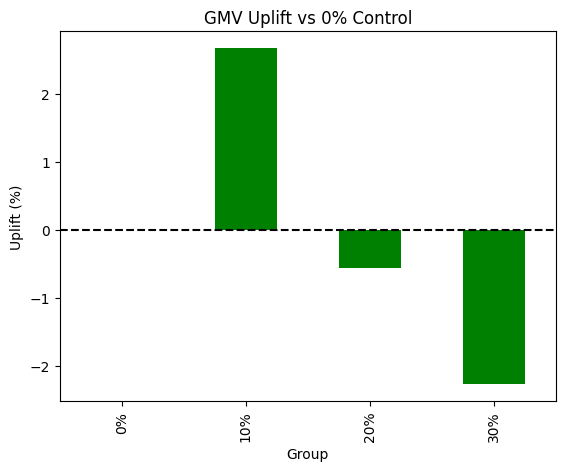

In [13]:
uplift_vs_control.plot(kind='bar', color='green', title='GMV Uplift vs 0% Control', ylabel='Uplift (%)', xlabel='Group')
plt.axhline(0, color='black', linestyle='--')
plt.show()

## Results Summary
Overall, the A/B test simulation did not show a statistically significant GMV uplift for higher discount levels. The 10% discount produced a small positive uplift (+2.67%) but was not statistically significant (p = 0.1765). Both 20% and 30% discounts resulted in negative GMV uplift.

The evidence suggests that offering very large discounts (20-30%) does not improve first order GMV, and may even reduce it. The 10% discount appears to be an optimal balance between promotion and profitability.

## Save Results

In [15]:
uplift_vs_control.to_csv('/Users/Cathaml/Desktop/gmv_uplift_summary.csv')